In [1]:
 ! ./scripts/get-data.sh

In [2]:
# Get new token from https://enigmalabs.io/graphql
jwt = "Bearer eyJhbGciOiJSUzI1NiIsInR5cCI6IkpXVCIsImtpZCI6IlVGa0I5cnRaS1RBVUVOaHR5YTBXZiJ9.eyJodHRwczovL2hhc3VyYS5pby9qd3QvY2xhaW1zIjp7IngtaGFzdXJhLWRlZmF1bHQtcm9sZSI6InVzZXIiLCJ4LWhhc3VyYS1hbGxvd2VkLXJvbGVzIjpbInVzZXIiLCJ1c2VyIl0sIngtaGFzdXJhLXVzZXItaWQiOiJhdXRoMHw2MDRmZTdiYmY0YzE0MzAwNzEwZGNlOWMiLCJ4LWhhc3VyYS11c2VyIjoiMSJ9LCJpc3MiOiJodHRwczovL2F1dGguZW5pZ21hbGFicy5pby8iLCJzdWIiOiJhdXRoMHw2MDRmZTdiYmY0YzE0MzAwNzEwZGNlOWMiLCJhdWQiOlsiaHR0cHM6Ly9lbmlnbWEtYXBwLnVzLmF1dGgwLmNvbS9hcGkvdjIvIiwiaHR0cHM6Ly9lbmlnbWEtYXBwLnVzLmF1dGgwLmNvbS91c2VyaW5mbyJdLCJpYXQiOjE2NDMzOTgyMjMsImV4cCI6MTY0MzQ4NDYyMywiYXpwIjoiZkhDQlNrMDM1SnV4bzQ4UVVjNnpsZGdCNTN5SW4zNDIiLCJzY29wZSI6Im9wZW5pZCBwcm9maWxlIGVtYWlsIHJlYWQ6Y3VycmVudF91c2VyIHVwZGF0ZTpjdXJyZW50X3VzZXJfbWV0YWRhdGEgZGVsZXRlOmN1cnJlbnRfdXNlcl9tZXRhZGF0YSBjcmVhdGU6Y3VycmVudF91c2VyX21ldGFkYXRhIGNyZWF0ZTpjdXJyZW50X3VzZXJfZGV2aWNlX2NyZWRlbnRpYWxzIGRlbGV0ZTpjdXJyZW50X3VzZXJfZGV2aWNlX2NyZWRlbnRpYWxzIHVwZGF0ZTpjdXJyZW50X3VzZXJfaWRlbnRpdGllcyIsImd0eSI6InBhc3N3b3JkIn0.byc1rZrIvbGSEIiqE_9fhkyEKoNJJ0HDM8L7acIffYCCQmeynz6p5iimLUxDTJJcGh_zoFW2Fe5pl866ax3UCYfAXgxKF96LRhWqg0IOwEtC3LJ22Z_Wi-SC5Qi-98pPGhfQEDb7ABE8BO6Nik7ss7tvC7wswTzjP69gLH4aMreNXXAfWPgb8QFjlNjUHme6Umee6n4nwyFNs8L9OcrxFj5moRepgEg2NyFmlDtLCVhVdAryBEPDU8Icb-TfOs5lp2mTG_dcwCa5Suz9I-b_C_IusApd5hNQlCDOeLCZ7oRtgcoYNekE3sy0YMmt-EoalBgnkWVz_ZOBPD2lBGkGrw"

# Default public token, do not modify
mapbox_token = "pk.eyJ1IjoiZW5pZ21hbGFicyIsImEiOiJja2prMzZ6NHA1YnppMnpucHIzdnc3d255In0.jPuo0Fn7BhDGGtlIQ1LotQ"

graphql_endpoint = 'https://gql.enigmalabs.io/v1/graphql'
headers = {'content-type': 'application/json',
           'Authorization': jwt,
           }
query = open("coastline_incidents.graphql", "r").read()


In [3]:
import requests
import json
import pandas as pd
from pandas import DataFrame
import geopandas as gpd
import shapely
import plotly.express as px
from geographiclib.geodesic import Geodesic
import plotly.graph_objects as go
import matplotlib as plt
import numpy as np


/opt/homebrew/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [4]:
geod = Geodesic.WGS84
shape_map = gpd.read_file('data/tl_2021_us_coastline.shp')

In [5]:
def flatten_json(nested_json, exclude=['']):
    """Flatten json object with nested keys into a single level.
        Args:
            nested_json: A nested json object.
            exclude: Keys to exclude from output.
        Returns:
            The flattened json object if successful, None otherwise.
    """
    out = {}

    def flatten(x, name='', exclude=exclude):
        if type(x) is dict:
            for a in x:
                if a not in exclude: flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(nested_json)
    return out

In [6]:
incident_request = requests.post(
    graphql_endpoint,
    json={'query': query}, headers=headers
)


In [7]:
json_data = json.loads(incident_request.text)
df = pd.DataFrame([flatten_json(x) for x in json_data['data']['incident_survey']]).head(10)

lon_lat = [df['incident_location_center_coordinates_0'], df['incident_location_center_coordinates_1']]
incident_series = gpd.GeoDataFrame(gpd.points_from_xy(lon_lat[0], lon_lat[1]))
df = df.assign(point=incident_series) 

In [18]:
incidents_fig = go.Figure(go.Scattermapbox(
        lat=df.incident_location_center_coordinates_1,
        lon=df.incident_location_center_coordinates_0,
        mode='markers',
        marker=go.scattermapbox.Marker(
            color='#ff5935'
        )
    ))
incidents_fig.update_layout(
    mapbox_style='satellite', mapbox_accesstoken=mapbox_token)
incidents_fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
incidents_fig.show()


In [9]:
coastline_df = gpd.GeoSeries(shape_map['geometry'])

# lats = []
# lons = []

# for linestring in coastline_df:
#     x, y = linestring.xy
#     lats = np.append(lats, y)
#     lons = np.append(lons, x)
#     lats = np.append(lats, None)
#     lons = np.append(lons, None)

# fig = px.line_mapbox(lat=lats, lon=lons, center=dict(lat=37, lon=-100), zoom=2,
#                      mapbox_style='satellite')
# fig.show()

In [10]:
gpd.options.use_pygeos = True
nearest = coastline_df.sindex.nearest(gpd.GeoSeries(df['point']), return_all=False)
shoreline_series = pd.Series(nearest[1], index=nearest[0]).apply(lambda x: coastline_df[x])
df = df.assign(shoreline=shoreline_series)

/opt/homebrew/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning:

The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.



In [11]:
def get_least_distance(lat1, lon1, shoreline_segment):
    least = float('inf')
    for lon, lat in shoreline_segment.coords:
        g = geod.Inverse(lat1, lon1, lat, lon)
        least = min(least, g['s12'])
    return least

In [12]:
meter_to_mile= 0.000621371
df['distance_miles'] = df.apply(lambda r: meter_to_mile*get_least_distance(r.point.coords[0][1], r.point.coords[0][0], r.shoreline), axis=1)

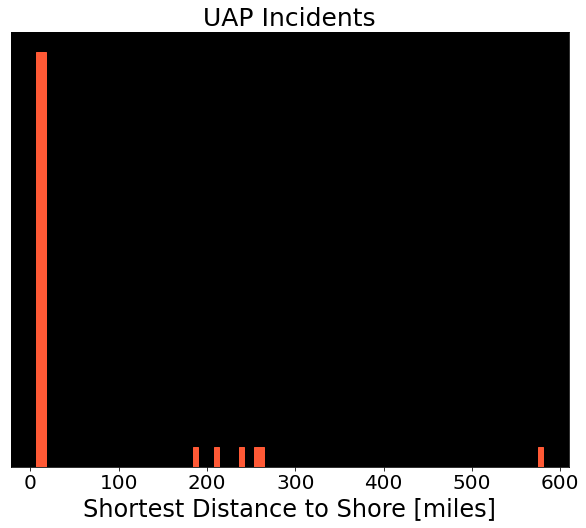

In [13]:
ax = df.hist(column='distance_miles', figsize=(10,8), bins=100, color='#ff5935', grid=False, edgecolor='#ff5935')
for x in ax.flatten():
  x.set_xlabel('Shortest Distance to Shore [miles]', size=24)
  x.set_ylabel('Number of Incidents', size=0)
  x.get_yaxis().set_visible(False)
  x.tick_params(axis='x', labelsize=20)
  x.set_title("UAP Incidents", size=25)
  x.set_yscale('log')
  x.set_facecolor('k')

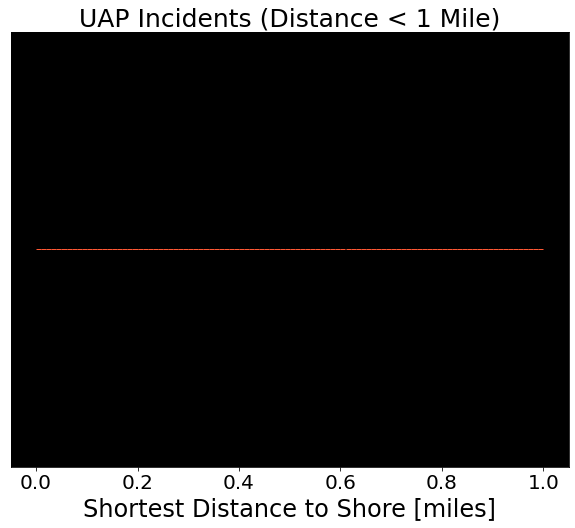

In [14]:
df_less_than_1_mile=df[df.distance_miles<1]
ax = df_less_than_1_mile.hist(column='distance_miles', figsize=(10,8), bins=100, color='#ff5935', grid=False, edgecolor='#ff5935')
for x in ax.flatten():
  x.set_xlabel('Shortest Distance to Shore [miles]', size=24)
  x.set_ylabel('Number of Incidents', size=0)
  x.get_yaxis().set_visible(False)
  x.tick_params(axis='x', labelsize=20)
  x.set_title("UAP Incidents (Distance < 1 Mile)", size=25)
  x.set_facecolor('k')

In [19]:
fig = go.Figure(go.Scattermapbox(
        lat=df_less_than_1_mile.incident_location_center_coordinates_1,
        lon=df_less_than_1_mile.incident_location_center_coordinates_0,
        mode='markers',
        marker=go.scattermapbox.Marker(
            color='#ff5935'
        )
    ))
fig.update_layout(mapbox_style='satellite', mapbox_accesstoken=mapbox_token)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()